# Bayesian Convolutional Neural Networks for Histopathological Image Classification

In [1]:
import torch
import csv
import os
import sys
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import torch.optim as optim

from PIL import Image
from torch.utils import data
from torchvision import transforms
from torchvision.transforms import ToTensor

In [2]:
# locate the modules required for Bayesian CNNs
sys.path.append('../PyTorch-BayesianCNN/Image Recognition/')

from utils.BBBlayers import GaussianVariationalInference
from utils.BayesianModels.BayesianLeNet import BBBLeNet

In [3]:
skip_training = False

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

print('using cuda: {}'.format(use_cuda))

using cuda: True


In [5]:
# csv which contains the IDs and labels for the training data
label_path = 'kaggle/train_labels.csv'

# we make a dictionary called labels, which pairs each ID with its label
with open(label_path, mode='r') as file:
    reader = csv.reader(file)
    next(reader) # skip the header
    labels = {row[0]: int(row[1]) for row in reader}

# we also store all the labels in a separate list
list_IDs = list(labels.keys())

In [6]:
# we use the Torch Dataset class to efficiently handle the data
class Dataset(data.Dataset):
    def __init__(self, list_IDs, labels, transform):
        self.labels = labels
        self.list_IDs = list_IDs
        self.transform = transform
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        filename = '{}.tif'.format(ID)
        
        filepath = os.path.join('kaggle', 'train', filename)
        image = Image.open(filepath)
        X = self.transform(image)
        y = self.labels[ID]
        
        return X, y

In [18]:
validation_split = 0.2
max_epochs = 100
num_samples = 10
resize = 32
beta_type = "Blundell"

In [8]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(resize),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

training_set = Dataset(list_IDs, labels, transform=transform)

In [9]:
n_train = len(training_set)
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(validation_split * n_train))

training_IDs, validation_IDs = indices[split:], indices[:split]

loader_params = {'batch_size': 32,
         'num_workers': 6}

In [10]:
training_sampler = data.SubsetRandomSampler(training_IDs)
validation_sampler = data.SubsetRandomSampler(validation_IDs)

training_loader = data.DataLoader(training_set, **loader_params,
                                 sampler=training_sampler)
validation_loader = data.DataLoader(training_set, **loader_params,
                                 sampler=validation_sampler)

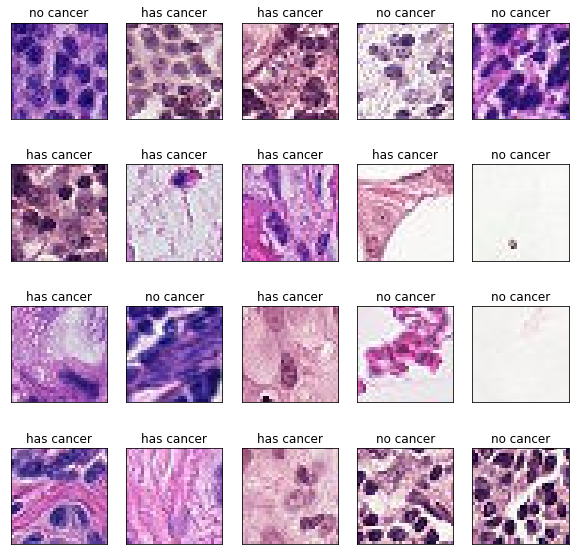

In [11]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

dataiter = iter(training_loader)
# obtain one batch of training images
images, labels = dataiter.next()
classes = ['no cancer', 'has cancer']

# plot a sample of 20 images from the batch along with labels
fig = plt.figure(figsize=(10, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
    
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [12]:
inputs = 3 # number of input channels
outputs = 2 # number of output classes

lr = 0.001
weight_decay = 0.0005

net = BBBLeNet(outputs, inputs)

net.to(device)

vi = GaussianVariationalInference(torch.nn.CrossEntropyLoss())
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

In [13]:
# Feed a batch of images from the training data to test the network
with torch.no_grad():
    dataiter = iter(training_loader)
    images, labels = dataiter.next()
    data = images.view(-1, inputs, 32, 32).repeat(num_samples, 1, 1, 1)
    labels = labels.repeat(num_samples)
    data = data.to(device)
    labels = labels.to(device)
    print('Shape of the input tensor:', data.shape)

    y, kl = net.probforward(data)
    # print(y)
    # print(kl)
    assert y.shape == torch.Size([32 * num_samples, 2]), "Bad shape of y: y.shape={}".format(y.shape)

print('The shapes seem to be ok.')

Shape of the input tensor: torch.Size([320, 3, 32, 32])
The shapes seem to be ok.


In [14]:
ckpt_name = f'model_LeNet_full_bayesian.pt'
ckpt_name

'model_LeNet_full_bayesian.pt'

In [19]:
#%%time

batch_size = loader_params['batch_size']

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, max_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    m = math.ceil(len(training_set) / batch_size)
    
    ###################
    # train the model #
    ###################
    net.train()
    for batch_idx, (data, target) in enumerate(training_loader):
        # move tensors to GPU if CUDA is available
        
        data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        target = target.repeat(num_samples)
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        if beta_type is "Blundell":
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        elif beta_type is "Soenderby":
            beta = min(epoch / (num_epochs // 4), 1)
        elif beta_type is "Standard":
            beta = 1 / m
        else:
            beta = 0
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output,kl = net.probforward(data)
        # calculate the batch loss
        loss = vi(output, target, kl, beta)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += (loss.item()*data.size(0)) / num_samples
        
        break
        
    # print('output: {}'.format(output))
    # print('kl: {}'.format(kl))
    ######################    
    # validate the model #
    ######################
    net.eval()
    for batch_idx, (data, target) in enumerate(validation_loader):
        data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        target = target.repeat(num_samples)
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output,kl = net.probforward(data)
        # calculate the batch loss
        loss = vi(output, target, kl, beta)

        # update average validation loss 
        valid_loss += (loss.item()*data.size(0)) / num_samples
        
        break
    
    # print('loss: {}'.format(loss))
    # print(loss.item())
    # print(data.size(0))
    # print(num_samples)
    # print(valid_loss)
        
    # calculate average losses
    train_loss = train_loss/(len(training_loader.dataset) * (1-validation_split))
    valid_loss = valid_loss/(len(validation_loader.dataset) * validation_split)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), ckpt_name)
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 8.973207 	Validation Loss: 35.773122
Validation loss decreased (inf --> 35.773122).  Saving model ...
Epoch: 2 	Training Loss: 8.959069 	Validation Loss: 35.672889
Validation loss decreased (35.773122 --> 35.672889).  Saving model ...
Epoch: 3 	Training Loss: 8.922214 	Validation Loss: 35.693370
Epoch: 4 	Training Loss: 8.896492 	Validation Loss: 35.563342
Validation loss decreased (35.672889 --> 35.563342).  Saving model ...
Epoch: 5 	Training Loss: 8.895716 	Validation Loss: 35.426969
Validation loss decreased (35.563342 --> 35.426969).  Saving model ...
Epoch: 6 	Training Loss: 8.864295 	Validation Loss: 35.355658
Validation loss decreased (35.426969 --> 35.355658).  Saving model ...
Epoch: 7 	Training Loss: 8.827345 	Validation Loss: 35.191143
Validation loss decreased (35.355658 --> 35.191143).  Saving model ...
Epoch: 8 	Training Loss: 8.814442 	Validation Loss: 35.089924
Validation loss decreased (35.191143 --> 35.089924).  Saving model ...
Epoch: 9 	Tra

Epoch: 68 	Training Loss: 7.259752 	Validation Loss: 28.927812
Validation loss decreased (29.042927 --> 28.927812).  Saving model ...
Epoch: 69 	Training Loss: 7.230129 	Validation Loss: 28.883212
Validation loss decreased (28.927812 --> 28.883212).  Saving model ...
Epoch: 70 	Training Loss: 7.197113 	Validation Loss: 28.759874
Validation loss decreased (28.883212 --> 28.759874).  Saving model ...
Epoch: 71 	Training Loss: 7.209833 	Validation Loss: 28.693734
Validation loss decreased (28.759874 --> 28.693734).  Saving model ...
Epoch: 72 	Training Loss: 7.143814 	Validation Loss: 28.569134
Validation loss decreased (28.693734 --> 28.569134).  Saving model ...
Epoch: 73 	Training Loss: 7.079390 	Validation Loss: 28.405289
Validation loss decreased (28.569134 --> 28.405289).  Saving model ...
Epoch: 74 	Training Loss: 7.122688 	Validation Loss: 28.446353
Epoch: 75 	Training Loss: 7.110686 	Validation Loss: 28.224611
Validation loss decreased (28.405289 --> 28.224611).  Saving model ...